In [1]:
### Header

# 3 - Modeling pipelines

In [58]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

SEED = 123
np.random.seed(SEED) # to have reproducible results

RANDOM_STATE = 42

In [3]:
data = pd.read_csv("../data/ctg_pp_02.csv")
data_copy = data.copy() # create checkpoint
data.head()

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Width,Min,Max,Nmax,Nzeros,Median,Variance,Tendency,CLASS,NSP
0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,...,64.0,62.0,126.0,2.0,0,121.0,73.0,2,8,1
1,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,...,130.0,68.0,198.0,6.0,1,140.0,12.0,1,5,0
2,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,...,130.0,68.0,198.0,5.0,1,138.0,13.0,1,5,0
3,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,...,117.0,53.0,170.0,11.0,0,137.0,13.0,2,5,0
4,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,...,117.0,53.0,170.0,9.0,0,138.0,11.0,2,1,0


### 3.1 - Train-test split

In [7]:
from sklearn.model_selection import train_test_split 

In [16]:
# We separate target from features
X = data.drop(columns = ["CLASS", "NSP"] ,axis=1)
y1 = data["CLASS"]
y2 = data["NSP"]

In [71]:
# Dataset 1
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.3, random_state=RANDOM_STATE)
ds_raw_class = [X_train, X_test, y1_train, y1_test]

[X_train.shape, X_test.shape, y1_train.shape, y1_test.shape]

[(1488, 19), (638, 19), (1488,), (638,)]

In [72]:
# Dataset 2
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.3, random_state=RANDOM_STATE)
ds_raw_nsp = [X_train, X_test, y2_train, y2_test]

[X_train.shape, X_test.shape, y2_train.shape, y2_test.shape]

[(1488, 19), (638, 19), (1488,), (638,)]

### 3.2 - Standardization

In [19]:
from sklearn.preprocessing import StandardScaler

In [45]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
X_train_scaled

array([[-0.20647709,  1.47380921, -0.19874521, ...,  0.6212933 ,
         0.09685987,  1.12223563],
       [ 0.89941853, -0.77429751, -0.19874521, ...,  0.6212933 ,
        -0.58074936, -0.51973745],
       [ 0.3967387 , -0.21227083, -0.19874521, ...,  0.2131324 ,
         0.13074033,  1.12223563],
       ...,
       [-1.11130078,  0.34975585, -0.19874521, ..., -0.80726984,
         0.40178402, -0.51973745],
       [-1.81505254,  0.06874251, -0.19874521, ..., -0.60318939,
         0.87611048, -0.51973745],
       [ 0.89941853, -0.49328417, -0.19874521, ...,  0.75734693,
        -0.51298844,  1.12223563]])

In [94]:
# With these two we have our 4 datasets to test
ds_std_class = [X_train_scaled, X_test_scaled, y1_train, y1_test]
ds_std_nsp = [X_train_scaled, X_test_scaled, y2_train, y2_test]

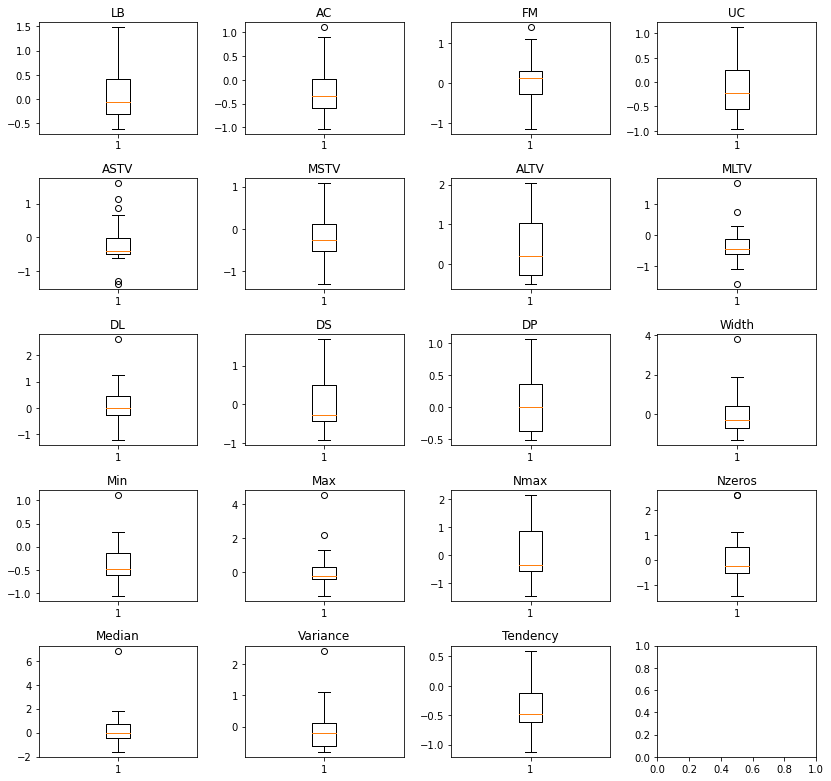

In [48]:
# Check standardisation with boxplots
# Can see that the mean is 0? Good

fig, axs = plt.subplots(5, 4, figsize = (12, 12))
axs = axs.flatten()

for column, ax, col_name in zip(X_train_scaled, axs, X_train.columns):
    ax.boxplot(column)
    ax.set_title(col_name)

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

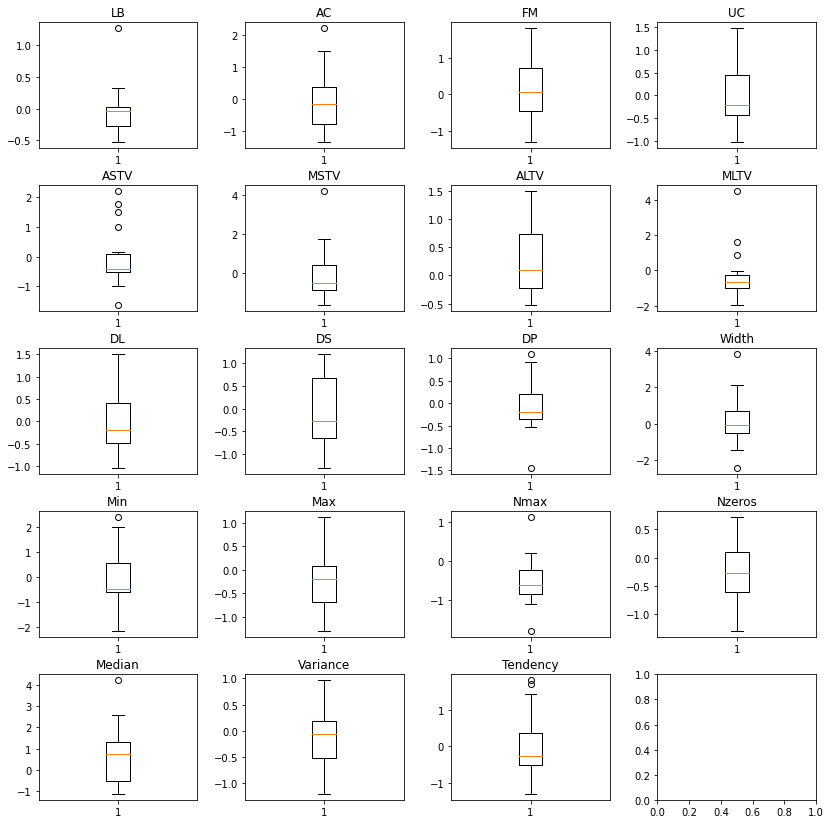

In [53]:
# Check standardisation with boxplots
# Could be a bit different for X_test

fig, axs = plt.subplots(5, 4, figsize = (12, 12))
axs = axs.flatten()

for column, ax, col_name in zip(X_test_scaled, axs, X_train.columns):
    ax.boxplot(column)
    ax.set_title(col_name)

fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95,
                    hspace=0.3, wspace=0.3)

### 3.3 - Modeling pipelines

We will train the following algorithms, hypertuning the appropiate parameters for each one (see below for details):

    # Logistic Regression (LG) 
    # k-Nearest Neighbors (kNN)
    # Support Vector Machine - Classifier (SVM)
    # Decision Tree (DT)
    # Random Forest (RF)

Given the number models to train, with their respective hyperparameters, plus the number of datasets to train (4), we will adopt a RandomizedSearch strategy. Contrary to GridSearch, in which every combination of paramater values are tried, RandomSearch sets up a grid of parameters and selects random combinations to train the model and score.

To evaluate the different output models, we will use the F1 score or harmonic mean of the precision (i.e. proportion of relevant instances correctly classified - true positives/true positives+false positives) and recall (i.e. proportion of the total amount of relevant instances correctly classified - true positives/true postitives+false negatives). F1 score reaches its best value at 1 (perfect precision and recall). In particular, we used the F1 micro score, which calculate metrics globally by counting the total true positives, false negatives and false positives.

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

#import joblib
#import time

In [55]:
# Build pipelines
pipe_lr = Pipeline([('clf', LogisticRegression())])
pipe_knn = Pipeline([('clf', KNeighborsClassifier())])
pipe_svm = Pipeline([('clf', svm.SVC())])
pipe_dt = Pipeline([('clf', DecisionTreeClassifier())])
pipe_rf = Pipeline([('clf', RandomForestClassifier())])

In [57]:
# Grid search parameters
param_range_1 = np.arange(0, 10, .1) # cost
param_range_2 = np.arange(2, 10) # n_neigghbors, max_dexpth, min_samples_leaf 
param_range_3 = np.arange(2, 20) # min_samples_split

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
                   'clf__C': param_range_1,
                   'clf__solver': ['liblinear', 'saga', 'lbfgs']}] 
grid_params_knn = [{'clf__n_neighbors': param_range_2}]
grid_params_svm = [{'clf__kernel': ['linear', 'rbf'],
                    'clf__gamma': ['auto','scale'],
                    'clf__C': param_range_1}]
grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
                   'clf__splitter': ['best','random'],
                   'clf__min_samples_leaf': param_range_2,
                   'clf__max_depth': param_range_2, 
                   'clf__min_samples_split': param_range_3}]
grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],              
                   'clf__min_samples_leaf': param_range_2, 
                   'clf__max_depth': param_range_2, 
                   'clf__min_samples_split': param_range_3}]             

In [90]:
# Build grid searches
kfold = StratifiedKFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
gs_lr = RandomizedSearchCV(estimator=pipe_lr, 
                           param_distributions=grid_params_lr,
                           scoring='f1_micro',
                           cv=kfold) 
gs_knn = RandomizedSearchCV(estimator=pipe_knn,
                            param_distributions=grid_params_knn,
                            scoring='f1_micro',
                            cv=kfold)
gs_svm = RandomizedSearchCV(estimator=pipe_svm,
                            param_distributions=grid_params_svm,
                            scoring='f1_micro',
                            cv=kfold)
gs_dt = RandomizedSearchCV(estimator=pipe_dt,
                           param_distributions=grid_params_dt,
                           scoring='f1_micro',
                           cv=kfold) 
gs_rf = RandomizedSearchCV(estimator=pipe_rf,
                           param_distributions=grid_params_rf,
                           scoring='f1_micro',
                           cv=kfold) 

In [ ]:
# We will iterate over the datasets and grid setups with different models
datasets_dict = {"raw_CLASS": ds_raw_class, 
                 "std_CLASS": ds_std_class, 
                 "raw_NSP": ds_raw_nsp, 
                 "std_NSP": ds_std_nsp}

grids_dict = {'Logistic Regression': gs_lr, 
             'k-Nearest Neighbors': gs_knn, 
             'Support Vector Machine': gs_svm, 
             'Decision Tree': gs_dt, 
             'Random Forest': gs_rf}

# Fit the grid search objects
print('Performing model optimisations...')
best_acc = 0.0
best_clf = 0
best_gs = ''

for n in range(0,5):
    print(f"\nRound:{n}")

    for ds in datasets_dict:
        print(f"\nDataset:{ds}")
        X_train, X_test, y_train, y_test = datasets_dict[ds][0], datasets_dict[ds][1], datasets_dict[ds][2], datasets_dict[ds][3]
        
        for model in grids_dict:
            print(f"\nEstimator: {model}; {ds}")
            # Fit grid search
            grids_dict[model].fit(X_train, y_train)
            # Best params
            print(f"Best params: {grids_dict[model].best_params_}")
            # Best training data accuracy
            print(f"Best training F1 score: {grids_dict[model].best_score_}")
            # Predict on test data with best params
            y_pred = grids_dict[model].predict(X_test)
            # Test data accuracy of model with best params
            print(f"Test set F1 score for best params: {f1_score(y_test, y_pred, average='micro')}")
            
            # Track best (highest test accuracy) model
            if accuracy_score(y_test, y_pred) > best_acc:
                best_acc = accuracy_score(y_test, y_pred)
                best_gs = grids_dict[model]
                best_ds = ds
    print(f"\n\nClassifier with best test set F1 score: {best_gs}, {best_ds}")


Performing model optimisations...

Round:0

Dataset:raw_CLASS

Estimator: Logistic Regression; raw_CLASS


/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/linear_mode

Best params: {'clf__solver': 'liblinear', 'clf__penalty': 'l2', 'clf__C': 7}
Best training F1 score: 0.80647106838382
Test set F1 score for best params: 0.8134796238244514

Estimator: k-Nearest Neighbors; raw_CLASS
Best params: {'clf__n_neighbors': 3}
Best training F1 score: 0.6626337747143116
Test set F1 score for best params: 0.731974921630094

Estimator: Support Vector Machine; raw_CLASS


/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver

Best params: {'clf__kernel': 'linear', 'clf__gamma': 'auto', 'clf__C': 4}
Best training F1 score: 0.823249591873753
Test set F1 score for best params: 0.8605015673981191

Estimator: Decision Tree; raw_CLASS
Best params: {'clf__splitter': 'best', 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 2, 'clf__max_depth': 10, 'clf__criterion': 'entropy'}
Best training F1 score: 0.8380464356974425
Test set F1 score for best params: 0.8401253918495298

Estimator: Random Forest; raw_CLASS
Best params: {'clf__min_samples_split': 4, 'clf__min_samples_leaf': 6, 'clf__max_depth': 7, 'clf__criterion': 'entropy'}
Best training F1 score: 0.8561944494830401
Test set F1 score for best params: 0.8652037617554859

Dataset:std_CLASS

Estimator: Logistic Regression; std_CLASS


/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/linear_mode

Best params: {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': 8}
Best training F1 score: 0.826600761835661
Test set F1 score for best params: 0.841692789968652

Estimator: k-Nearest Neighbors; std_CLASS
Best params: {'clf__n_neighbors': 3}
Best training F1 score: 0.7171095592236532
Test set F1 score for best params: 0.7460815047021945

Estimator: Support Vector Machine; std_CLASS
Best params: {'clf__kernel': 'rbf', 'clf__gamma': 'auto', 'clf__C': 7}
Best training F1 score: 0.8326818429167423
Test set F1 score for best params: 0.8589341692789969

Estimator: Decision Tree; std_CLASS
Best params: {'clf__splitter': 'best', 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 3, 'clf__max_depth': 7, 'clf__criterion': 'gini'}
Best training F1 score: 0.8515009976419373
Test set F1 score for best params: 0.85423197492163

Estimator: Random Forest; std_CLASS
Best params: {'clf__min_samples_split': 6, 'clf__min_samples_leaf': 2, 'clf__max_depth': 10, 'clf__criterion': 'gini'}
Best trai

/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:/

Best params: {'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__C': 2}
Best training F1 score: 0.8978596045710139
Test set F1 score for best params: 0.8918495297805643

Estimator: k-Nearest Neighbors; raw_NSP


/Users/bduar/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'clf__n_neighbors': 3}
Best training F1 score: 0.890472519499365
Test set F1 score for best params: 0.9028213166144201

Estimator: Support Vector Machine; raw_NSP
